In [1]:
import findspark as fs

import random
import os
import sys
import numpy as np

print(sys.executable)
print(sys.path)
print(sys.version)

import photutils
from photutils import detect_threshold
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.functional_models import Gaussian2D

#from pyspark.sql.types import Row
from pyspark import SparkContext
from pyspark.sql import SparkSession

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
import time

import shutil
from math import pi, log, sqrt

import warnings
warnings.filterwarnings("ignore")

/home/s2494876/miniconda3/envs/sddm/bin/python
['/home/s2494876/miniconda3/envs/sddm/lib/python36.zip', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6/lib-dynload', '', '/home/s2494876/.local/lib/python3.6/site-packages', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6/site-packages', '/home/s2494876/.local/lib/python3.6/site-packages/IPython/extensions', '/home/s2494876/.ipython']
3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]


In [2]:
try:
    sc = SparkContext(appName="SDDM") #, master='spark://fs.dslc.liacs.nl:7078')
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

In [3]:
# Define data paths
DR2_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2/"
mosaic_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/"

In [4]:
# Take a look at the data in a .fits file
hdul = fits.open(mosaic_path + "P004+38_mosaic-blanked.fits")
data = hdul[0].data # The intensity data
print(hdul[0].__dict__)

{'_header_str': None, '_file': <astropy.io.fits.file._File <_io.FileIO name='/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P004+38_mosaic-blanked.fits' mode='rb' closefd=True>>, '_buffer': None, '_header_offset': 0, '_data_offset': 2880, '_data_size': 735744960, '_data_replaced': False, '_data_needs_rescale': False, '_new': False, '_output_checksum': False, '_checksum': None, '_checksum_valid': None, '_datasum': None, '_datasum_valid': None, '_do_not_scale_image_data': False, '_uint': True, '_scale_back': None, '_bzero': 0, '_bscale': 1, '_axes': [9590, 9590], '_bitpix': -64, '_gcount': 1, '_pcount': 0, '_blank': None, '_orig_bitpix': -64, '_orig_blank': None, '_orig_bzero': 0, '_orig_bscale': 1, '_modified': False, '_header': SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions             

In [5]:
x = hdul[0]._header['NAXIS1']
y = hdul[0]._header['NAXIS2']

center = (x/2, y/2)

finite_area = np.sum(np.isfinite(data))
radius = np.sqrt(finite_area/pi)

w = WCS(hdul[0].header)
ra, dec = w.all_pix2world(x/2, y/2, 0, ra_dec_order=True)




In [6]:
def mosaic(file):
    hdul = fits.open(file)
    data = hdul[0].data # The intensity data
    conv = hdul[0]._header["BMAJ"]
        
    x = hdul[0]._header['NAXIS1']
    y = hdul[0]._header['NAXIS2']
    center = (x/2, y/2)

    finite_area = np.sum(np.isfinite(data))
    radius = np.sqrt(finite_area/pi) * conv

    w = WCS(hdul[0].header)
    ra, dec = w.all_pix2world(x/2, y/2, 0, ra_dec_order=True)
    
    # mosaic_dict[mosaic] = np.array((np.nan, np.nan, np.nan))
    #mosaic_dict[mosaic][0] = radius
    #mosaic_dict[mosaic][1] = ra
    #mosaic_dict[mosaic][2] = dec
    return np.array((radius, ra, dec))

In [7]:
fits_files = [mosaic_path + f for f in os.listdir(mosaic_path)]
random.shuffle(fits_files)
file_paths = sc.parallelize(fits_files, 8) # , len(fits_files)
file_paths.collect()

['/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P223+52_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P174+57_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P4Hetdex16_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P022+34_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P18Hetdex03_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P205+42_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P236+48_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P245+55_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P10Hetdex_mosaic-blanked.fits',
 '/data/astronomy-big-data/b

In [8]:
test = file_paths.map(lambda fits: (mosaic(fits)))
info = test.collect()

In [9]:
type(info)
info[0]

array([  8.57999485, 223.43031569,  52.49101666])

In [10]:
overlap_dict = {k.split('/')[-1]: [] for k in fits_files}

for i, f1 in enumerate(fits_files):
    f1 = f1.split('/')[-1]
    for j, f2 in enumerate(fits_files):
        if j > i:
            f2 = f2.split('/')[-1]
            offset = np.array((info[i][1] - info[j][1], info[i][2] - info[j][2]))
            distance = np.sqrt(np.sum(np.power(offset, 2)))
            radius = info[i][0] + info[j][0]
            if distance <= radius:
                overlap_dict[f1].append(f2)
                overlap_dict[f2].append(f1)

In [15]:
with open(os.path.join('overlap_dict.csv'), 'w') as outfile:
    outfile.write('fitsfile,center_ra,center_dec,radius,overlaps')
    for i, fi in enumerate(fits_files):
        outfile.write('\n{},{},{},{},{}'.format(fi.split('/')[-1], info[i][1], info[i][2], info[i][0], ';'.join(overlap_dict[f1])))

with open(os.path.join('overlap_dict_header.csv'), 'w') as outfile:
    outfile.write('fitsfile,center_ra,center_dec,radius,overlaps')

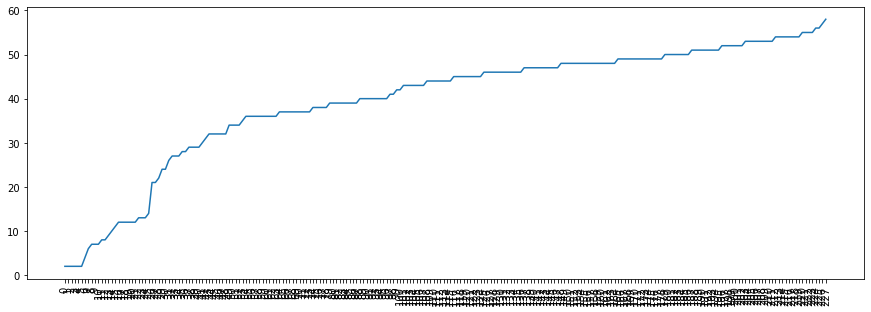

In [12]:
import matplotlib.pyplot as plt

x = range(len(fits_files))
y = [len(overlap_dict[i]) for i in overlap_dict.keys()]

labels = [fits_files[X].split('/')[-1] for Y, X in sorted(zip(y,x), key=lambda pair: pair[0])]

#print(labels)

fig = plt.figure(figsize=(15,5))
plt.xticks(range(len(labels)), rotation=90)
plt.plot(x, sorted(y))

In [121]:
labels[-20:]

['P206+50_mosaic-blanked.fits',
 'P155+55_mosaic-blanked.fits',
 'P160+55_mosaic-blanked.fits',
 'P154+50_mosaic-blanked.fits',
 'P219+52_mosaic-blanked.fits',
 'P221+47_mosaic-blanked.fits',
 'P227+55_mosaic-blanked.fits',
 'P214+52_mosaic-blanked.fits',
 'P210+52_mosaic-blanked.fits',
 'P9Hetdex01_mosaic-blanked.fits',
 'P159+52_mosaic-blanked.fits',
 'P231+53_mosaic-blanked.fits',
 'P223+52_mosaic-blanked.fits',
 'P155+52_mosaic-blanked.fits',
 'P13Hetdex12_mosaic-blanked.fits',
 'P227+53_mosaic-blanked.fits',
 'P215+50_mosaic-blanked.fits',
 'P225+47_mosaic-blanked.fits',
 'P219+50_mosaic-blanked.fits',
 'P211+50_mosaic-blanked.fits']

In [122]:
labels[:20]

['P121+32_mosaic-blanked.fits',
 'P345+33_mosaic-blanked.fits',
 'P112+37_mosaic-blanked.fits',
 'P335+26_mosaic-blanked.fits',
 'P347+26_mosaic-blanked.fits',
 'P116+34_mosaic-blanked.fits',
 'P000+38_mosaic-blanked.fits',
 'P004+38_mosaic-blanked.fits',
 'P036+31_mosaic-blanked.fits',
 'P037+39_mosaic-blanked.fits',
 'P006+36_mosaic-blanked.fits',
 'P013+26_mosaic-blanked.fits',
 'P007+39_mosaic-blanked.fits',
 'P034+39_mosaic-blanked.fits',
 'P035+34_mosaic-blanked.fits',
 'P030+39_mosaic-blanked.fits',
 'P022+34_mosaic-blanked.fits',
 'P027+31_mosaic-blanked.fits',
 'P012+36_mosaic-blanked.fits',
 'P016+34_mosaic-blanked.fits']